# HIV Treatment Using Optimal Control
### Lehner White

## Problems 1 & 2:
HIV attacks T-cells that fight off viruses, causing a weakened immune system and leads to AIDS. 

AIDS is treated by bolstering the immune system and strengthening T-cell counts. 

In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import seaborn

## Problem 3:

In [2]:
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y✬ = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i✬th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in xrange(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

In [3]:
a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_f = 50
n = 1000

# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([T0, V0])
costate = np.zeros((n,2))
costate0 = np.zeros(2)
u=np.zeros((n,2))
u[:,0] += .02
u[:,1] += .9

# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
    
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the T cell concentration and the virus
        concentration at time t
    '''
    T, V = y[0], y[1]
    
    Tp = s_1 - (s_2 * V)/(B_1 + V) - mu*T - k*V*T + u[i,0]*T
    Vp = (g*V)/(B_2 + V)*(1 - u[i,1]) - c*V*T
    
    return np.array([Tp,Vp])

## Problem 4:

In [4]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    '''
    L1 , L2 = y[0], y[1]
    
    T, V = state[-i,0], state[-i, 1]
    u1, u2 = u[-i, 0], u[-i, 1]
    
    L1p = L1*(-mu - k*V + u1) - c*L2*V - 1
    L2p = -L1*((s_2*B_1)/(B_1 + V)**2 + k*T) \
            + L2*((g*B_2*(1-u2))/(B_2 + V)**2 - c*T)
        
    return np.array([L1p, L2p])

## Problem 5:

In [5]:
epsilon = 0.001
test = epsilon + 1
t0 = 0

time = np.linspace(t0, t_f, n)
a1v = np.linspace(a_1, a_1, n)
b1v = np.linspace(b_1, b_1, n)
a2v = np.linspace(a_2, a_2, n)
b2v = np.linspace(b_2, b_2, n)

while(test > epsilon):
    oldu = u.copy();
    
    #solve the state equations with forward iteration
    state = RK4(state_equations, np.array([T0, V0]), t0, t_f, n)
    T, V = state[:,0], state[:,1]
    
    #solve the costate equations with backwards iteration
    costate= RK4(lambda_hat, np.array([0,0]), t0, t_f, n)[::-1]
    L1, L2 = costate[:,0], costate[:,1]
    
    #solve for u1 and u2
    u1 = (-1/(2*A_1)*np.multiply(L1, T))
    u1 = np.minimum( np.maximum(a1v, u1), b1v )
    
    u2 = 1/(2*A_2)*np.multiply(L2, ((g*V)/(B_2 + V)))
    u2 = np.minimum( np.maximum( a2v, u2), b2v)
    
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    
    #test for convergence
    test = abs(oldu - u).sum()

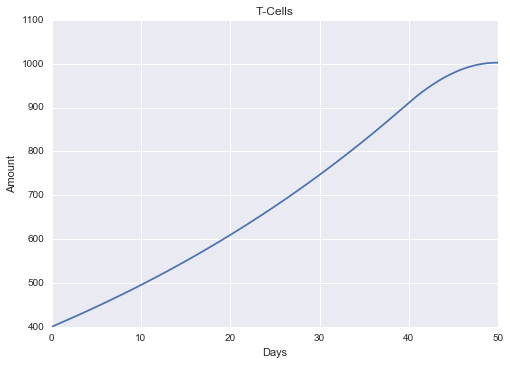

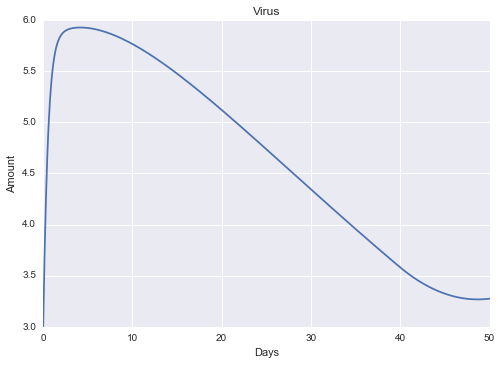

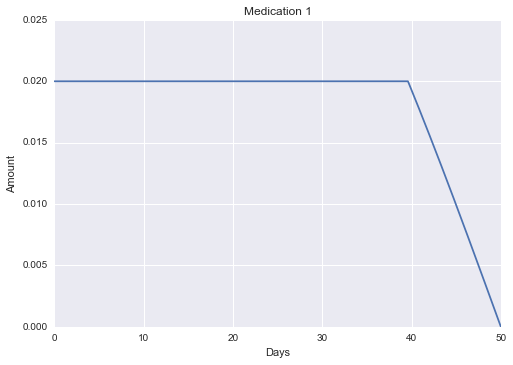

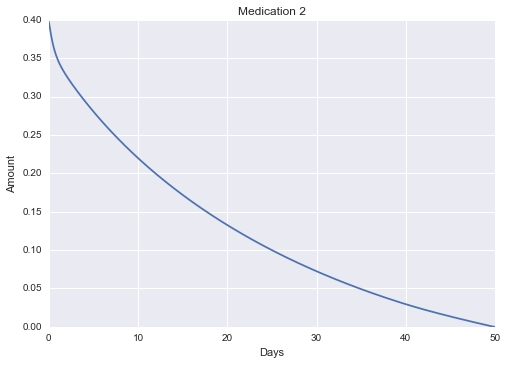

In [6]:
titles = ['T-Cells', 'Virus', 'Medication 1', 'Medication 2']
vals = [T, V, u1, u2]

for i in xrange(len(vals)):
    plt.plot(time, vals[i])
    plt.title(titles[i])
    plt.xlabel('Days')
    plt.ylabel('Amount')
    plt.show()